In [21]:
from collections import Counter
import os
import regex as re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import pprint
import time

In [508]:
# Useful groups for regular expressions
HS_CODE = r'(\d+\.\d+)(?:\.\w+)?'
HS_CODE_NC = r'(?:\d+\.\d+)(?:\.\w+)?'
HS_RANGE = r'({0}(?:\-{0})?)'.format(HS_CODE)
HS_RANGE_NC = r'{0}(?:\-{0})?'.format(HS_CODE_NC)

In [529]:
class RoO:
    def __init__(self, name, raw_text, hs_map):
        # Replace en dash with hyphen
        self.name = name
        self.hs_map = hs_map
        self.roo_struct = RoO.parse_roo(re.sub(r'\s?–\s?', '-', raw_text))
        self.unique_rules = RoO.expand_rules(self.roo_struct)
        self.rules = RoO.expand_rules(self.roo_struct, complete=True, hs_map=self.hs_map)
        self.restrictions = RoO.restrictions_list(self.unique_rules, self.hs_map, search_patterns)
        # Make patterns a class variable???
    
    def get_roo_struct(self):
        return self.roo_struct
        
    def get_unique_rules(self):
        return self.unique_rules
    
    def get_rules(self):
        return self.rules
    
    def get_restrictions(self):
        return self.restrictions
    
    def __len__(self):
        return len(self.rules)
    
    @staticmethod
    def parse_roo(roo_text):
        """Given complete text of specific rules of origin, return a dictionary representing
        the complete structure of RoO (from sections to chapters)

        Argument:
            roo_text
        Return:

        """
        # Capture sections
        pattern_section = re.compile(r'(?i)(Section\s+[IVX]{1,5})\s+(.+?)(?=Section\s+[IVX]{1,5}\s+[A-Z\-]|\Z)', flags=re.DOTALL)
        result = pattern_section.findall(roo_text)
        roo_struct = {match[0]: match[1] for match in result}

        # Capture chapters in every section
        pattern_chapter = re.compile(r'(Chapter\s+\d{1,2})\s+(.+?)(?=Chapter\s+\d{1,2}\s+[A-Z]|\Z)', flags=re.DOTALL)
        for section, content in roo_struct.items():
            result = pattern_chapter.findall(content)
            roo_struct[section] = {match[0]: match[1] for match in result}

        # Capture rules in every chapter
        pattern_rule = re.compile(HS_RANGE + r'\s+([A-Z].+?\.)(?=\s+' + HS_RANGE_NC + r'|\s*\Z)', flags=re.DOTALL)
        pattern_whitespace = re.compile(r'\s+')    
        for section in roo_struct:
            for chapter, rules in roo_struct[section].items():
                result = pattern_rule.findall(rules)
                roo_struct[section][chapter] = {match[0]: pattern_whitespace.sub(lambda x: ' ', match[3]) for match in result}
        return roo_struct

    @staticmethod
    def expand_rules(roo_struct, complete=False, hs_map=None):
        """Create a dictionary which only stores the rules without additional stuctures"""
        roo_rules = {}
        # UPDATE: WILL NOT ALLOW TARIFF ITEM RULES -> instead of directly compiling HS_RANGE, use a modified version
        pattern_range = re.compile(r'({0}(?:\-{0})?)'.format(r'(\d+\.\d+)'))
        for section in roo_struct:
            for chapter in roo_struct[section]:
                for hs_code_range, rule in roo_struct[section][chapter].items():
                    if complete:
                        # I use findall instead of search since it returns '' instead of None
                        result = pattern_range.findall(hs_code_range)
                        if not result[0][1]:
                            continue
                        hs_codes = hs_map.get_hs_codes(result[0][1], result[0][2])
                        for hs_code in hs_codes:
                            roo_rules[hs_code] = rule
                    else:
                        roo_rules[hs_code_range] = rule
        return roo_rules

    @staticmethod
    def restrictions_list(unique_rules, hs_map, search_patterns):
        """From the roo structure, classify the rules.
        Side note: There is aliasing in _EST, but as long as restrictions is read-only, then there would be no problem.
        """
        restrictions = {}
        pattern_range = re.compile(HS_RANGE)
        for hs_code_range, rule in unique_rules.items():
            # Get HS codes
            result = pattern_range.findall(hs_code_range)
            hs_codes = hs_map.get_hs_codes(result[0][1], result[0][2])

            # CLASSIFY THE RULES
            for pattern in search_patterns.values():
                result = pattern.search(hs_codes, rule, hs_map)
                if result:
                    for hs_final in hs_codes:
                        all_restrictions = pattern.finalize(hs_final, result, hs_map)
                        for hs_intermediate in all_restrictions:
                            restrictions.setdefault(hs_intermediate, set()).add(hs_final)
                    break #if needed
        
        return restrictions

    def plot_chapter_restrictions(self):
        freq = Counter()
        for hs_code in self.restrictions:
            freq[hs_code[:2]] += len(self.restrictions[hs_code])
            
        restrictions_by_chapter = [0 for i in range(98)]
        for key, value in freq.items():
            restrictions_by_chapter[int(key)] = value

        plt.plot(range(98), restrictions_by_chapter, label=self.name)
        plt.xlabel('HS Chapter')
        plt.ylabel('Total Restrictiveness Index')
        
    def scatter_plot(self):
        chapters = []
        restrictiveness_index = []
        for hs_code in self.restrictions:
            chapters.append(int(hs_code[:2])/10)
            restrictiveness_index.append(len(self.restrictions[hs_code]))

        plt.scatter(chapters, restrictiveness_index)
        plt.xlabel('HS Chapter (first digit)')
        plt.ylabel('Restrictiveness Index')
        
    def restrictions_table(self):
        """Return a DataFrame"""
        data = {'VAAR_dummy': [], 'output_str': [], 'input_str': []}
        for hs_intermediate, hs_finals in self.restrictions.items():
            for hs_final in hs_finals:
                data['VAAR_dummy'].append(0)
                data['output_str'].append(hs_final)
                data['input_str'].append(hs_intermediate)
        return pd.DataFrame.from_dict(data)

In [526]:
class HS_map():
    def __init__(self, version, dataframe):
        self.version = version
        self.dataframe = dataframe
        self.full_map = HS_map.expand_map(self.dataframe)
        self.length = dataframe.loc[dataframe['Tier'] == 3]['ProductCode'].count()
        
    def get_map(self):
        return self.dataframe
    
    def get_full_map(self):
        return self.full_map
    
    def __len__(self):
        return self.length
    
    # CREATE A DICTIONARY FOR FASTER ACCESS TO ALL HS CODES
    @staticmethod
    def expand_map(df):
        """Given part of HS code (chapter, heading, or subheading), return list
        containing all 6-digit HS code within it.
        
        Could have implemented this as a recursive data structure, but would be slower.
        Just want the benefit of hash table fast access.
        """
        full_map = {}
        # Expand chapters
        chapters = df.loc[df['Tier'] == 1]
        for row in chapters.itertuples(index=False, name=None):
            result = df.loc[(df['ProductCode'].str.startswith(row[1])) & (df['Tier'] == 3)]
            full_map[row[1]] = list(result['ProductCode'])

        # Expand headings
        headings = df.loc[df['Tier'] == 2]
        for row in headings.itertuples(index=False, name=None):
            result = df.loc[(df['ProductCode'].str.startswith(row[1])) & (df['Tier'] == 3)]
            full_map[row[1]] = list(result['ProductCode'])

        # Expand subheadings
        subheadings = df.loc[df['Tier'] == 3]
        for row in subheadings.itertuples(index=False, name=None):
            full_map[row[1]] = [row[1]]

        return full_map

    
    # FUNCTION FOR EXTRACTING HS CODES
    def get_hs_codes(self, hs_code1, hs_code2=''):
        """Given a range of HS codes, return list of all HS codes within."""
        # Clean HS codes
        hs_code1 = hs_code1.replace('.', '')
        hs_code2 = hs_code2.replace('.', '')
        hs_map = self.dataframe
        
        if not hs_code2:
            return self.full_map[hs_code1]

        try:
            # Is there a way to index by value? HS_map['ProductCode'].indval(hs_code) ?
            index_1 = hs_map.loc[hs_map['ProductCode'] == hs_code1].index[0]
            index_2 = hs_map.loc[hs_map['ProductCode'] == hs_code2].index[0]

            range_1 = hs_map.loc[hs_map['Tier'] == 3].loc[index_1:index_2]
            range_2 = hs_map.loc[(hs_map['ProductCode'].str.startswith(hs_code2)) & (hs_map['ProductCode'] != hs_code2)
                                 & (hs_map['Tier'] == 3)]

            result = pd.concat([range_1, range_2], ignore_index=True)
            return list(result['ProductCode'])

        except:
            print(hs_code1, hs_code2)

In [527]:
class RoO_pattern:
    # class variable
    pattern_multirange = re.compile(UNIV_RANGE_TEXT)
    
    def __init__(self, name, category, pattern):
        self.name = name
        self.pattern = re.compile(pattern)
        self.group = category['OTG']
        self.exception = category['ECT']
        self.exemption = category['EXM']
        self.multi = category['MUL']
        self.indices = self.get_indices()
    
    def search(self, hs_codes, rule, hs_map):
        # In general, beware of search(), it might accidentally return None instead of ''
        # -> Look at the patterns rules carefully
        match = self.pattern.search(rule)
        if match:
            try:
                digits = self.classify(match[self.indices['CTC']])
                restrictions, handle = set(), {}
                if self.group:
                    restrictions |= self.get_restrictions(hs_codes, digits, hs_map)
                else:
                    handle['OTG'] = digits

                if self.exception:
                    restrictions |= self.get_exceptions(match[self.indices['ECT']], hs_map)

                if self.exemption:
                    exemptions = self.get_exemptions(match[self.indices['EXM']], hs_codes, hs_map)
                    pattern_1_res = re.compile(r'any other {0} within'.format(HS_TIER)).search(match[self.indices['EXM']])
                    handleDigits = self.classify(pattern_1_res[1]) if pattern_1_res else None
                    handle['EXM'] = (exemptions, handleDigits)

                if self.multi:
                    handle['MUL'] = self.get_exemptions(match[self.indices['MUL']], hs_codes, hs_map)
            except:
                print(rule)

            return restrictions, handle
        else:
            return None
        
    def finalize(self, hs_code, result, hs_map):
        restrictions, handle = result
        if 'OTG' in handle:
            digits = handle['OTG']
            restrictions = restrictions | self.get_restrictions([hs_code], digits, hs_map)
        if 'EXM' in handle:
            # Hopefully no error
            exemptions, butSelf = handle['EXM']
            if butSelf:
                exemptions = exemptions - self.get_restrictions([hs_code], butSelf, hs_map)
            restrictions = restrictions - exemptions
        if 'MUL' in handle:
            # I doubt this is the right way...
            restrictions = restrictions - handle['MUL']
        return restrictions
    
    def get_indices(self):
        indices = {}
        if self.multi:
            indices['MUL'] = 1
            indices['CTC'] = 2
            if self.exception:
                indices['ECT'] = 3
            if self.exemption:
                indices['EXM'] = 3
        else:
            indices['CTC'] = 1
            if self.exception:
                indices['ECT'] = 2
            if self.exemption:
                indices['EXM'] = 3 if self.exception else 2
        return indices
            
    @staticmethod
    def classify(tier):
        """Classify tier and return corresponding digits"""
        if tier == 'chapter':
            digits = 2
        elif tier == 'heading':
            digits = 4
        elif tier == 'subheading' or tier == 'tariff item':
            digits = 6
        else:
            raise ValueError
        return digits
        
    @staticmethod
    def get_restrictions(hs_codes, digits, hs_map):
        restrictions = set()
        unique_levels = set([hs_code[:digits] for hs_code in hs_codes])
        for level in unique_levels:
            restrictions |= set(hs_map.get_hs_codes(level))
        return restrictions
    
    @staticmethod
    def get_exceptions(clause, hs_map):
        exceptions = set()
        for ch_1, ch_2, hs_code1, hs_code2 in RoO_pattern.pattern_multirange.findall(clause):
            if ch_1:
                ch_1, ch_2 = ch_1.zfill(2), ch_2.zfill(2) if ch_2 else ch_2
                exceptions |= set(hs_map.get_hs_codes(ch_1, ch_2))
            else:
                exceptions |= set(hs_map.get_hs_codes(hs_code1, hs_code2))
        return exceptions
    
    @staticmethod
    def get_exemptions(clause, hs_codes, hs_map):
        exemptions = set()    
        for ch_1, ch_2, hs_code1, hs_code2 in RoO_pattern.pattern_multirange.findall(clause):
            if ch_1:
                ch_1, ch_2 = ch_1.zfill(2), ch_2.zfill(2) if ch_2 else ch_2
                exemptions |= set(hs_map.get_hs_codes(ch_1, ch_2))
            else:
                exemptions |= set(hs_map.get_hs_codes(hs_code1, hs_code2))
        
        group_exempt = re.compile(r'any other {0} within that group'.format(HS_TIER))
        if group_exempt.search(clause):
            # assumption, {0} always subheading
            exemptions |= RoO_pattern.get_restrictions(hs_codes, 6, hs_map)
            
        anti_exempt = re.compile(r'any subheading outside that group')
        if anti_exempt.search(clause):
            exemptions -= RoO_pattern.get_restrictions(hs_codes, 6, hs_map)
        
        return exemptions

In [528]:
HS_RANGE_TEXT = r'(?:heading|subheading|tariff item) {0}(?: through {0})?'.format(HS_CODE)
HS_RANGE_TEXT_NC = r'(?:heading|subheading|tariff item) {0}(?: through {0})?'.format(HS_CODE_NC)
HS_TIER = r'(chapter|heading|subheading|tariff item)'
HS_TIER_NC = r'(?:[Cc]hapter|heading|subheading|tariff item)'
CH_NUMBER = r'(\d\d?)\b(?!\.\d)'
CH_NUMBER_NC = r'(?:\d\d?)\b(?!\.\d)'
# Tariff item is truncated into 6 digit
UNIV_RANGE_TEXT = r'(?:{0}(?: through {0})?|{1}(?: through {1})?)'.format(CH_NUMBER, HS_CODE)
UNIV_RANGE_TEXT_NC = r'(?:{0}(?: through {0})?|{1}(?: through {1})?)'.format(CH_NUMBER_NC, HS_CODE_NC)
# NOTE TO SELF: I CHANGED MULTI (NO MORE LOOKAHEAD ON 'any other', AND ALSO CTC1_MULTI -> MORE SPECIFIC)
MULTI0 = r'((?:\s|or|,|{0}|{1}|any (?:other )?{0}|including another|within|outside|that group)+)'.format(HS_TIER_NC, UNIV_RANGE_TEXT_NC)
MULTI0_NC = r'(?:\s|or|,|{0}|{1}|any (?:other )?{0}|including another|within|outside|that group)+'.format(HS_TIER_NC, UNIV_RANGE_TEXT_NC)
# Could actually use possessive quantifier ++, but would result in less captures (some escape), and also comma whether negative lookahead
MULTI = r'((?:U.S.|Canadian|Mexican|\s|or|and|,|-|{0}|{1}|any (?:other )?{0}|including another|within|outside|that group|more than one of the following:|[^;]+of {0} {1})+)'.format(HS_TIER_NC, UNIV_RANGE_TEXT_NC)
MULTI_NC = r'(?:U.S.|Canadian|Mexican|\s|or|and|,|-|{0}|{1}|any (?:other )?{0}|including another|within|outside|that group|more than one of the following:|[^;]+of {0} {1})+'.format(HS_TIER_NC, UNIV_RANGE_TEXT_NC)
INCLUDE = r'(?:, including another {0} within that group)?'.format(HS_TIER_NC)

# (?: [^;]+? of)?
CTC = r'A change to {0} from any other {1}{2}'.format(HS_RANGE_TEXT_NC, HS_TIER, INCLUDE)
CTC_OTG = r'A change to {0} from any(?: other)? {1} outside that group'.format(HS_RANGE_TEXT_NC, HS_TIER)
CTC_ECT = r'A change to {0} from any other {1}{2}, except from {3}'.format(HS_RANGE_TEXT_NC, HS_TIER, INCLUDE, MULTI)
CTC_OTG_ECT = r'A change to {0} from any(?: other)? {1} outside that group, except from {2}'.format(HS_RANGE_TEXT_NC, HS_TIER, MULTI)
# CTC1 Multi, need better way
CTC1_MULTI = r'A change to {0} from {1} or any other {2}'.format(HS_RANGE_TEXT_NC, MULTI, HS_TIER)
CTC1_MULTI_ECT = r'A change to {0} from {1} or any other {2}, except from {3}'.format(HS_RANGE_TEXT_NC, MULTI, HS_TIER, MULTI)
CTC2_MULTI = r'A change to {0} from {1}, whether or not there is also a change from any(?: other)? {2}(?: outside that group)?(?:, including another {2} within (?:{0}|that group)?)?'.format(HS_RANGE_TEXT_NC, MULTI, HS_TIER_NC)
MFTc = r'No required change in tariff classification to {0}, provided(?: that)? non-?originating materials used undergo a chemical reaction(?:, purification, isomer separation or biotechnological processes)? in a Party'.format(HS_RANGE_TEXT_NC)
RVC = r'(?:No(?: required)? change in tariff classification to {0}(?: is required)?, )?provided(?: that)? there is a (?:qualifying|regional) value content of not less than(?:\: (?:a\.|\(a\)))? (\d\d?) per\s?cent(?: under the net cost method| (?:when|where) the (?:[Bb]uild-?down|transaction value) method is used, or (?:of not less than|b\.|\(b\)) (\d\d?) per\s?cent (?:when|where) the (?:[Bb]uild-?up|net cost) method is used)?'.format(HS_RANGE_TEXT_NC)

raw_patterns = {
    'CTC': re.compile(r'^{0}\.$'.format(CTC)),
    'CTCo': re.compile(r'^{0}\.$'.format(CTC_OTG)),
    'CTCe': re.compile(r'^{0}\.$'.format(CTC_ECT)),
    'CTCoe': re.compile(r'^{0}\.$'.format(CTC_OTG_ECT)),
    'CTCm': re.compile(r'^{0}\.$'.format(CTC1_MULTI)),
    'CTCme': re.compile(r'^{0}\.$'.format(CTC1_MULTI_ECT)),
    
    'CTC+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC, RVC)),
    'CTCo+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC_OTG, RVC)),
    'CTCe+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC_ECT, RVC)),
    'CTCoe+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC_OTG_ECT, RVC)),
    'CTCm+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC1_MULTI, RVC)),
    'CTCme+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC1_MULTI_ECT, RVC)),
    
    'CTC_or_RVC': re.compile(r'^{0}; or {1}\.$'.format(CTC, RVC)),
    'CTC_or_MFTc': re.compile(r'^{0}; or {1}\.$'.format(CTC, MFTc)),
    'CTC_or_RVC_or_MFTc': re.compile(r'^{0}; {1}; or {2}\.$'.format(CTC, RVC, MFTc)),
    'CTCe_or_RVC': re.compile(r'^{0}; or {1}\.$'.format(CTC_ECT, RVC)),
    
    'CTC1_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC, CTC2_MULTI, RVC)),
    'CTC1o_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC_OTG, CTC2_MULTI, RVC)),
    'CTC1e_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC_ECT, CTC2_MULTI, RVC)),
    'CTC1oe_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC_OTG_ECT, CTC2_MULTI, RVC)),
    'CTC1m_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC1_MULTI, CTC2_MULTI, RVC)),
    
    # Need to refine the first multi {0}
    'CTCr': re.compile(r'^A change to {0} from {0} or any other {1}; or A change to {0} from(?: {0} or)? any other {2}\.$'.format(MULTI_NC, HS_TIER, HS_TIER_NC)),

    # Not finished
    'CTC+RVCUNIV': re.compile(r'^{0}, provided that (?:[^;](?!\Z|(?:qualifying|regional) value content))+\.$'.format(CTC)),
    'CTCe+RVCUNIV': re.compile(r'^{0}, provided that (?:[^;](?!\Z|(?:qualifying|regional) value content))+\.$'.format(CTC_ECT))
}

pattern_categories = {
    'CTC': {'OTG': False, 'ECT': False, 'EXM': False, 'MUL': False},
    'CTCo': {'OTG': True, 'ECT': False, 'EXM': False, 'MUL': False},
    'CTCe': {'OTG': False, 'ECT': True, 'EXM': False, 'MUL': False},
    'CTCoe': {'OTG': True, 'ECT': True, 'EXM': False, 'MUL': False},
    'CTCm': {'OTG': False, 'ECT': False, 'EXM': False, 'MUL': True},
    'CTCme': {'OTG': False, 'ECT': True, 'EXM': False, 'MUL': True},
    
    'CTC+RVC': {'OTG': False, 'ECT': False, 'EXM': False, 'MUL': False},
    'CTCo+RVC': {'OTG': True, 'ECT': False, 'EXM': False, 'MUL': False},
    'CTCe+RVC': {'OTG': False, 'ECT': True, 'EXM': False, 'MUL': False},
    'CTCoe+RVC': {'OTG': True, 'ECT': True, 'EXM': False, 'MUL': False},
    'CTCm+RVC': {'OTG': False, 'ECT': False, 'EXM': False, 'MUL': True},
    'CTCme+RVC': {'OTG': False, 'ECT': True, 'EXM': False, 'MUL': True},
    
    'CTC_or_RVC': {'OTG': False, 'ECT': False, 'EXM': False, 'MUL': False},
    'CTC_or_MFTc': {'OTG': False, 'ECT': False, 'EXM': False, 'MUL': False},
    'CTC_or_RVC_or_MFTc': {'OTG': False, 'ECT': False, 'EXM': False, 'MUL': False},
    'CTCe_or_RVC': {'OTG': False, 'ECT': True, 'EXM': False, 'MUL': False},
    
    'CTC1_or_CTC2m+RVC': {'OTG': False, 'ECT': False, 'EXM': True, 'MUL': False},
    'CTC1o_or_CTC2m+RVC': {'OTG': True, 'ECT': False, 'EXM': True, 'MUL': False},
    'CTC1e_or_CTC2m+RVC': {'OTG': False, 'ECT': True, 'EXM': True, 'MUL': False},
    'CTC1oe_or_CTC2m+RVC': {'OTG': True, 'ECT': True, 'EXM': True, 'MUL': False},
    'CTC1m_or_CTC2m+RVC': {'OTG': False, 'ECT': False, 'EXM': True, 'MUL': True},
    
    'CTCr': {'OTG': False, 'ECT': False, 'EXM': False, 'MUL': False},
    
    'CTC+RVCUNIV': {'OTG': False, 'ECT': False, 'EXM': False, 'MUL': False},
    'CTCe+RVCUNIV': {'OTG': False, 'ECT': True, 'EXM': False, 'MUL': False}
}

search_patterns = {}
for name, category in pattern_categories.items():
    search_patterns[name] = RoO_pattern(name, category, raw_patterns[name])

In [386]:
# Read csv files of different versions of HS code mapping
hs_maps = {
    1992: HS_map('1992', pd.read_csv('HS0_h.csv')),
    2002: HS_map('2002', pd.read_csv('HS2.csv')),
    2007: HS_map('2007', pd.read_csv('HS3.csv')),
    2012: HS_map('2012', pd.read_csv('HS4.csv')),
    2017: HS_map('2017', pd.read_csv('HS5.csv'))
}

# Read the HS code version used in each agreement
hs_version = {}
for row in pd.read_csv('HS_ver.csv').itertuples(index=None, name=None):
    hs_version[row[0]] = hs_maps[row[1]]

In [247]:
# Read RoO data
roo_texts = {}
roo_folder = 'RoO Non-table/roo_clean_2'

# roo_clean_2 -> UTF-8 ('cause Ms. Word?), roo_clean -> ANSI
for filename in os.listdir(roo_folder):
    with open(roo_folder + '/' + filename, mode='r', encoding='utf-8') as f:
        roo_texts[filename[:-4]] = f.read()

# Create instances of RoO
roo = {}
for fta, roo_text in roo_texts.items():
    roo[fta] = RoO(fta, roo_text, hs_version[fta])
    print(fta)
    

# Check how many sections within the RoO
# Apparently India is missing some sections: X, XIV, XIX, XXI
#pattern_count = re.compile('Section [IVX]{1,5}')
#for fta in roo:
#    print(fta, len(roo[fta].get_roo_struct()))

BRN_JPN
CHL_JPN
IDN_JPN
IND_JPN
JPN_MEX
JPN_MYS
JPN_PER
JPN_PHL
JPN_THA


In [60]:
print(hs_maps[2002].get_hs_codes('39.06', '39.07'))

['390610', '390690', '390710', '390720', '390730', '390740', '390750', '390760', '390791', '390799']


In [107]:
for fta in roo:
    print(fta, len(roo[fta]))
    
# NOTE!!!
# JPN_PHL, 15.16 - 15.19 -> TYPO??? CHANGE TO 15.18

for ver, hs_map in hs_maps.items():
    print('HS', ver, ':', len(hs_map))

BRN_JPN 5222
CHL_JPN 5212
IDN_JPN 5210
IND_JPN 2474
JPN_MEX 5224
JPN_MYS 5158
JPN_PER 5047
JPN_PHL 5222
JPN_THA 5214
HS 2002 : 5224
HS 2007 : 5052
HS 2012 : 5205
HS 2017 : 6276


In [64]:
#one = set(get_roo_rules(parse_roo(roo_texts['IND_JPN'], get_hs_map('IND_JPN'), complete=True)))
#two = set(get_roo_rules(parse_roo(roo_texts['JPN_PER'], get_hs_map('JPN_PER'), complete=True)))
#sorted(list(two-one))
#roo_texts['IND_JPN']

In [15]:
unique_rules = {fta: roo[fta].get_unique_rules() for fta in roo}

In [251]:
# NEXT PROJECT: ANALYZE GRAMMAR
HS_RANGE_TEXT = r'(?:heading|subheading|tariff item) {0}(?: through {0})?'.format(HS_CODE)
HS_RANGE_TEXT_NC = r'(?:heading|subheading|tariff item) {0}(?: through {0})?'.format(HS_CODE_NC)
HS_TIER = r'(chapter|heading|subheading|tariff item)'
HS_TIER_NC = r'(?:[Cc]hapter|heading|subheading|tariff item)'
CH_NUMBER = r'(\d\d?)\b(?!\.\d)'
CH_NUMBER_NC = r'(?:\d\d?)\b(?!\.\d)'
# Tariff item is truncated into 6 digit
UNIV_RANGE_TEXT = r'(?:{0}(?: through {0})?|{1}(?: through {1})?)'.format(CH_NUMBER, HS_CODE)
UNIV_RANGE_TEXT_NC = r'(?:{0}(?: through {0})?|{1}(?: through {1})?)'.format(CH_NUMBER_NC, HS_CODE_NC)
# NOTE TO SELF: I CHANGED MULTI (NO MORE LOOKAHEAD ON 'any other', AND ALSO CTC1_MULTI -> MORE SPECIFIC)
MULTI0 = r'((?:\s|or|,|{0}|{1}|any (?:other )?{0}|including another|within|outside|that group)+)'.format(HS_TIER_NC, UNIV_RANGE_TEXT_NC)
MULTI0_NC = r'(?:\s|or|,|{0}|{1}|any (?:other )?{0}|including another|within|outside|that group)+'.format(HS_TIER_NC, UNIV_RANGE_TEXT_NC)
# Could actually use possessive quantifier ++, but would result in less captures (some escape), and also comma whether negative lookahead
MULTI = r'((?:\s|or|and|,|-|{0}|{1}|any (?:other )?{0}|including another|within|outside|that group|more than one of the following:|[^;]+of {0} {1})+)'.format(HS_TIER_NC, UNIV_RANGE_TEXT_NC)
MULTI_NC = r'(?:\s|or|and|,|-|{0}|{1}|any (?:other )?{0}|including another|within|outside|that group|more than one of the following:|[^;]+of {0} {1})+'.format(HS_TIER_NC, UNIV_RANGE_TEXT_NC)
INCLUDE = r'(?:, including another {0} within that group)?'.format(HS_TIER_NC)

# (?: [^;]+? of)?
CTC = r'A change to {0} from any other {1}{2}'.format(HS_RANGE_TEXT_NC, HS_TIER, INCLUDE)
CTC_OTG = r'A change to {0} from any(?: other)? {1} outside that group'.format(HS_RANGE_TEXT_NC, HS_TIER)
CTC_ECT = r'A change to {0} from any other {1}{2}, except from {3}'.format(HS_RANGE_TEXT_NC, HS_TIER, INCLUDE, MULTI)
CTC_OTG_ECT = r'A change to {0} from any(?: other)? {1} outside that group, except from {2}'.format(HS_RANGE_TEXT_NC, HS_TIER, MULTI)
# CTC1 Multi, need better way
CTC1_MULTI = r'A change to {0} from {1} or any other {2}'.format(HS_RANGE_TEXT_NC, MULTI, HS_TIER)
CTC1_MULTI_ECT = r'A change to {0} from {1} or any other {2}, except from {3}'.format(HS_RANGE_TEXT_NC, MULTI, HS_TIER, MULTI)
CTC2_MULTI = r'A change to {0} from {1}, whether or not there is also a change from any(?: other)? {2}(?: outside that group)?(?:, including another {2} within (?:{0}|that group)?)?'.format(HS_RANGE_TEXT_NC, MULTI, HS_TIER_NC)
MFTc = r'No required change in tariff classification to {0}, provided(?: that)? non-?originating materials used undergo a chemical reaction(?:, purification, isomer separation or biotechnological processes)? in a Party'.format(HS_RANGE_TEXT_NC)
RVC = r'(?:No(?: required)? change in tariff classification to {0}(?: is required)?, )?provided(?: that)? there is a (?:qualifying|regional) value content of not less than(?:\: a\.)? (\d\d?) per\s?cent(?: under the net cost method| (?:when|where) the (?:[Bb]uild-?down|transaction value) method is used, or (?:of not less than|b\.) (\d\d?) per\s?cent (?:when|where) the (?:[Bb]uild-?up|net cost) method is used)?'.format(HS_RANGE_TEXT_NC)

patterns = {
    'CTC': re.compile(r'^{0}\.$'.format(CTC)),
    'CTCo': re.compile(r'^{0}\.$'.format(CTC_OTG)),
    'CTCe': re.compile(r'^{0}\.$'.format(CTC_ECT)),
    'CTCoe': re.compile(r'^{0}\.$'.format(CTC_OTG_ECT)),
    'CTCm': re.compile(r'^{0}\.$'.format(CTC1_MULTI)),
    'CTCme': re.compile(r'^{0}\.$'.format(CTC1_MULTI_ECT)),
    
    'CTC+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC, RVC)),
    'CTCo+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC_OTG, RVC)),
    'CTCe+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC_ECT, RVC)),
    'CTCoe+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC_OTG_ECT, RVC)),
    'CTCm+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC1_MULTI, RVC)),
    'CTCme+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC1_MULTI_ECT, RVC)),
    
    'CTC_or_RVC': re.compile(r'^{0}; or {1}\.$'.format(CTC, RVC)),
    'CTC_or_MFTc': re.compile(r'^{0}; or {1}\.$'.format(CTC, MFTc)),
    'CTC_or_RVC_or_MFTc': re.compile(r'^{0}; {1}; or {2}\.$'.format(CTC, RVC, MFTc)),
    'CTCe_or_RVC': re.compile(r'^{0}; or {1}\.$'.format(CTC_ECT, RVC)),
    
    'CTC1_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC, CTC2_MULTI, RVC)),
    'CTC1o_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC_OTG, CTC2_MULTI, RVC)),
    'CTC1e_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC_ECT, CTC2_MULTI, RVC)),
    'CTC1oe_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC_OTG_ECT, CTC2_MULTI, RVC)),
    'CTC1m_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC1_MULTI, CTC2_MULTI, RVC)),
    
    # Need to refine the first multi {0}
    'CTCr': re.compile(r'^A change to {0} from {0} or any other {1}; or A change to {0} from(?: {0} or)? any other {2}\.$'.format(MULTI_NC, HS_TIER, HS_TIER_NC)),
    
    # Unfinished, beware of end, consider "provided that"?
    'CTCi': re.compile(r'^{0}; or A change to [^;]+ of {1} from {2}\.$'.format(CTC, HS_RANGE_TEXT_NC, MULTI_NC, HS_TIER_NC)),
    'CTCoi': re.compile(r'^{0}; or A change to [^;]+ of {1} from {2}\.$'.format(CTC_OTG, HS_RANGE_TEXT_NC, MULTI_NC, HS_TIER_NC)),
      
    'RVC': re.compile(r'^(?:{0}|A qualifying value content of not less than \d\d? percent)\.$'.format(RVC)),
    'WO': re.compile(r'^(?:Manufacture in which all the materials used are wholly obtained\.|Goods of (?:heading|subheading) {0}(?: through {0})? are wholly obtained or produced entirely in a Party\,? as defined in Article \d\d?\.)$'.format(HS_CODE_NC)),
    'WO_scrap': re.compile(r'^No required change in tariff classification to {0}, provided(?: that)? the waste(?: and scrap are)?(?: is)? wholly obtained or produced entirely in (?:a Party|the Area of one or both Parties|the territory of a Country) as defined in Article \d\d?(?: of Chapter \d\d?)?\.$'.format(HS_RANGE_TEXT_NC)),
    
    'Manufacture': re.compile(r'^Manufacture from (?:yarns|fibres|fabrics|chemical materials or textile pulps)(?:, provided that necessary process stipulated in the Appendix is undertaken)?\.$'),

    'CTC+asean': re.compile(r'^{0}, provided? that, where non-?originating materials of (?:[\w\W]+) are used, each of the non-?originating materials is (?:[^;]+) in (?:(?:either Party or )?a non-?Party|the territory of either Country or a third State) which is a member country of the ASEAN\.$'.format(CTC)),
    'CTCo+asean': re.compile(r'^{0}, provided that, where non-?originating materials of (?:[\w\W]+) are used, each of the non-?originating materials is (?:[^;]+) in either Party or a non-?Party which is a member country of the ASEAN\.$'.format(CTC_OTG)),
    'CTC+asean_or_Manufacture': re.compile(r'^{0}, provided? that, where non-?originating materials of (?:[\w\W]+) are used, each of the non-?originating materials is (?:[\w\W]+) in either Party or a non-?Party which is a member country of the ASEAN; or No required change in tariff classification to {1}, provided that the good is (?:[\w\W]+) and that the non-?originating material of that group is (?:[\w\W]+) in either Party or a non-?Party which is a member country of the ASEAN.$'.format(CTC, HS_RANGE_TEXT_NC)),
    'CTCo+asean_or_Manufacture': re.compile(r'^{0}, provided that, where non-?originating materials of (?:[\w\W]+) are used, each of the non-?originating materials (?:[\w\W]+) in either Party or a non-?Party which is a member country of the ASEAN; or No required change in tariff classification to {1}, provided that the good is (?:[\w\W]+) and that the non-?originating material of that group is (?:[\w\W]+) in either Party or a non-?Party which is a member country of the ASEAN.$'.format(CTC_OTG, HS_RANGE_TEXT_NC)),
    
    'CTC+RVCUNIV': re.compile(r'^{0}, provided that (?:[^;](?!\Z|(?:qualifying|regional) value content))+\.$'.format(CTC)),
    'CTCe+RVCUNIV': re.compile(r'^{0}, provided that (?:[^;](?!\Z|(?:qualifying|regional) value content))+\.$'.format(CTC_ECT)),
    'CTCo+RVCUNIV': re.compile(r'^{0}, provided that (?:[^;](?!\Z|(?:qualifying|regional) value content))+\.$'.format(CTC_OTG)),
    'CTCoe+RVCUNIV': re.compile(r'^{0}, provided that (?:[^;](?!\Z|(?:qualifying|regional) value content))+\.$'.format(CTC_OTG_ECT)),
    
    'CC_fishing': re.compile(r'^A change to {0} from any other chapter, provided that, where non-originating materials of (?:[\w\W]+) are used, each of the non-originating materials is (?:obtained by fishing) in a non-?Party which is a member country of the ASEAN or taken by vessels, which are registered in and sail under the flag of a non-Party which is a member country of the ASEAN, from the sea outside the territorial sea of that non-Party\.$'.format(HS_RANGE_TEXT_NC)),
    
    'pattern_1': re.compile(r'^All the animals of Chapter 1 shall be wholly obtained\.$')
}

# Note for tomorrow: Change the get_rules so that it will render the more compact version of rules

start = time.time()
for fta in unique_rules:
    count = 0
    for rule in unique_rules[fta].values():
        res = []
        for pattern in patterns.values():
            res.append(pattern.search(rule))
        if any(res):
            #print(pattern1.search(rule))
            continue
        count += 1
        if fta == 'JPN_MEX':
            pass
            #print(rule, end='\n\n')
    print(fta, count)
    #print(begin, end='\n\n')
print(time.time()-start)

BRN_JPN 16
CHL_JPN 11
IDN_JPN 11
IND_JPN 7
JPN_MEX 18
JPN_MYS 31
JPN_PER 21
JPN_PHL 13
JPN_THA 25
0.5425493717193604


In [252]:
# COUNT FREQUENCY
for fta in roo:
    freq = Counter()
    for hsc, rule in roo[fta].get_rules().items():
        more = []
        for name, pattern in patterns.items():
            if pattern.search(rule):
                freq[name] += 1
                #break
                more.append(name)
                if name == 'CTCe':
                    pass
                    #print(rule, end='\n\n')
        if len(more) > 1:
            print(more)
            print(rule, end='\n\n')
                
    covered = sum(freq.values())
    total = len(roo[fta])
    
    print(fta)
    print('Counter : ', end='')
    pprint.pprint(freq.most_common(3))
    print(covered, '/', total, '({:2.2%})'.format(covered / total), end='\n\n')

BRN_JPN
Counter : [('CTC_or_RVC', 2348), ('CTC_or_RVC_or_MFTc', 945), ('CTC', 870)]
4944 / 5222 (94.68%)

CHL_JPN
Counter : [('CTC', 2729), ('CTC_or_RVC_or_MFTc', 944), ('CTC_or_RVC', 442)]
4897 / 5212 (93.96%)

IDN_JPN
Counter : [('CTC_or_RVC', 2345), ('CTC_or_RVC_or_MFTc', 958), ('CTC', 826)]
5161 / 5210 (99.06%)

IND_JPN
Counter : [('CTC', 796), ('Manufacture', 766), ('WO', 724)]
2463 / 2474 (99.56%)

JPN_MEX
Counter : [('CTC', 2461), ('CTC1_or_CTC2m+RVC', 778), ('CTCe', 586)]
5195 / 5224 (99.44%)

JPN_MYS
Counter : [('CTC_or_RVC', 3272), ('CTC', 761), ('CTC+asean', 351)]
4764 / 5158 (92.36%)

JPN_PER
Counter : [('CTC_or_RVC', 3028), ('CTC', 833), ('CTCe', 523)]
4573 / 5047 (90.61%)

JPN_PHL
Counter : [('CTC_or_RVC', 3112), ('CTC', 911), ('CTC+asean', 363)]
5163 / 5222 (98.87%)

JPN_THA
Counter : [('CTC_or_RVC', 2043), ('CTC', 1055), ('CTC_or_RVC_or_MFTc', 876)]
4885 / 5214 (93.69%)



In [135]:
roo['IDN_JPN'].get_rules()['270210']

'A change to subheading 2702.10 through 2703.00 from any other chapter 2704.00-2709.00 A change to subheading 2704.00 through 2709.00 from any other subheading; or No required change in tariff classification to subheading 2704.00 through 2709.00, provided that there is a qualifying value content of not less than 40 percent.'

In [133]:
# Restricted products over all products listed in the fta (NOT THE HS_MAP)
for fta in roo:
    covered = len(roo[fta].get_restrictions())
    total = len(roo[fta])
    print(fta, covered, '/', total,
          '({:2.2%})'.format(covered / total), '|', len(roo[fta].hs_map))

BRN_JPN 4766 / 5222 (91.27%) | 5224
CHL_JPN 4941 / 5212 (94.80%) | 5224
IDN_JPN 4822 / 5210 (92.55%) | 5224
IND_JPN 2121 / 2474 (85.73%) | 5052
JPN_MEX 5212 / 5224 (99.77%) | 5224
JPN_MYS 4787 / 5158 (92.81%) | 5224
JPN_PER 4663 / 5047 (92.39%) | 5052
JPN_PHL 4794 / 5222 (91.80%) | 5224
JPN_THA 5131 / 5214 (98.41%) | 5224


In [134]:
set(roo['IDN_JPN'].get_restrictions()) - set(roo['IDN_JPN'].get_rules())

{'270400',
 '270500',
 '270600',
 '270710',
 '270720',
 '270730',
 '270740',
 '270750',
 '270760',
 '270791',
 '270799',
 '270810',
 '270820',
 '270900'}

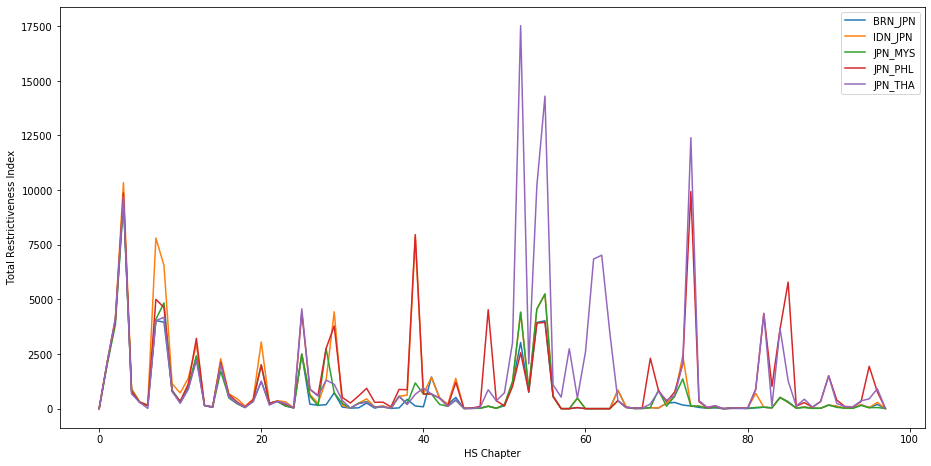

In [136]:
plt.figure(figsize=(15.5,7.75))
for fta in roo:
    # HS 2007
    if fta == 'IND_JPN' or fta == 'JPN_PER':
        continue
    # North america
    if fta == 'CHL_JPN' or fta == 'JPN_MEX':
        continue
    roo[fta].plot_chapter_restrictions()
plt.legend()
    
#plt.plot(range(98), pool['BRN_JPN'])
#plt.plot(range(98), pool['CHL_JPN'])
#plt.plot(range(98), pool['IDN_JPN'])
#plt.plot(range(98), pool['IND_JPN'])
#plt.plot(range(98), pool['JPN_MEX'])
#plt.plot(range(98), pool['JPN_MYS'])
#plt.plot(range(98), pool['JPN_PER'])
#plt.plot(range(98), pool['JPN_PHL'])
#plt.plot(range(98), pool['JPN_THA'])

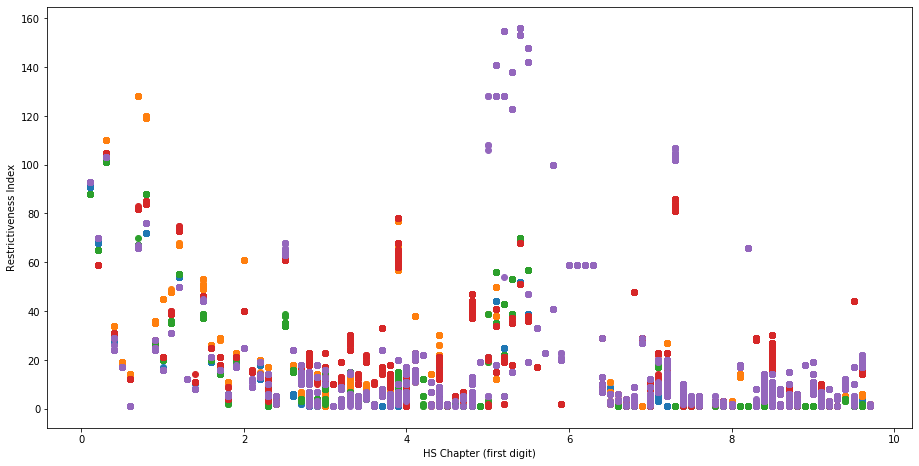

In [137]:
plt.figure(figsize=(15.5,7.75))
for fta in roo:
    # HS 2007
    if fta == 'IND_JPN' or fta == 'JPN_PER':
        continue
    # North america
    if fta == 'CHL_JPN' or fta == 'JPN_MEX':
        pass
        continue
    roo[fta].scatter_plot()
#plt.legend()

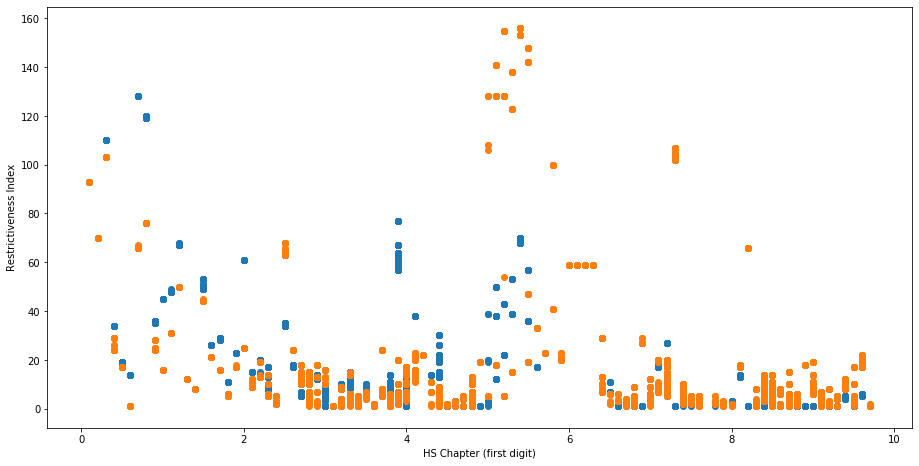

In [138]:
plt.figure(figsize=(15.5,7.75))
roo['IDN_JPN'].scatter_plot()
roo['JPN_THA'].scatter_plot()

In [395]:
heading_restriction = {fta: Counter() for fta in roo}
for fta in roo:
    headings = roo[fta].hs_map.dataframe.loc[roo[fta].hs_map.dataframe['Tier'] == 2, 'ProductCode']
    for heading in headings:
        for hs_code in roo[fta].hs_map.get_hs_codes(heading):
            heading_restriction[fta][heading] += len(roo[fta].get_restrictions().get(hs_code, []))
    #print(fta)
    #pprint.pprint(heading_restriction[fta], width=35)

In [ ]:
"""
pprint.pprint(freq, width=35)
print('FTA\t\tChapter\t\tHeading\t\tSubheading\tOther\t\tTotal')
for fta, rules in roo_rules.items():
    total = len(rules)
    try:
        chapter = roo_types_count[fta]['chapter'] / total
        heading = roo_types_count[fta]['heading'] / total
        subheading = roo_types_count[fta]['subheading'] / total
    except:
        continue
    other = 1 - (chapter + heading + subheading)
    print('{}\t\t{:2.2%}\t\t{:2.2%}\t\t{:2.2%}\t\t{:2.2%}\t\t{}'.format(fta, chapter, heading, subheading, other, total))
"""

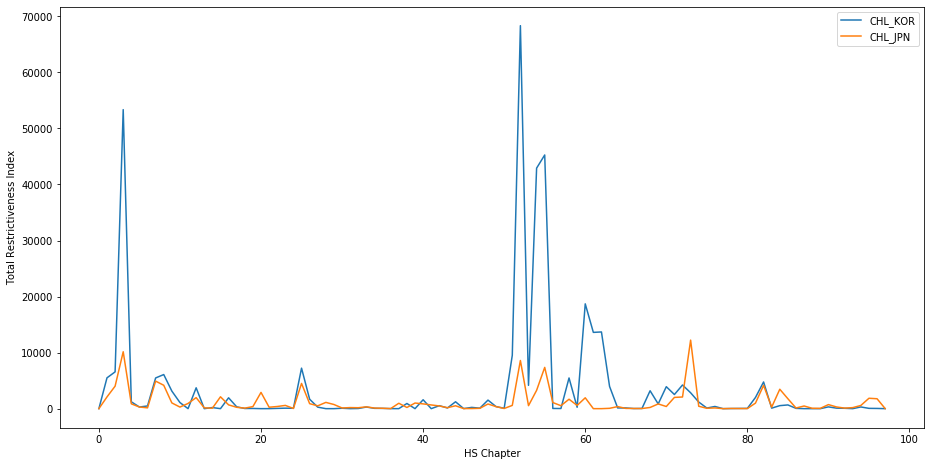

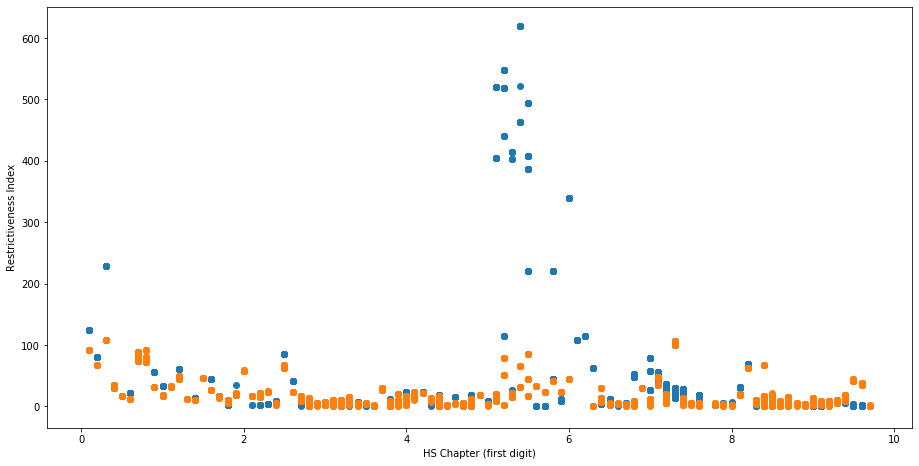

In [139]:
# NEXT PROJECT: KOREA
with open('CHL_KOR.txt', mode='r', encoding='utf-8') as f:
    # Replace en dash with hyphen
    chl_kor = f.read()

CHL_KOR = RoO('CHL_KOR', chl_kor, hs_maps[2017])

plt.figure(figsize=(15.5,7.75))
CHL_KOR.plot_chapter_restrictions()
roo['CHL_JPN'].plot_chapter_restrictions()
plt.legend()

plt.figure(figsize=(15.5,7.75))
CHL_KOR.scatter_plot()
roo['CHL_JPN'].scatter_plot()

# TO-DO: Normalize different versions of HS code

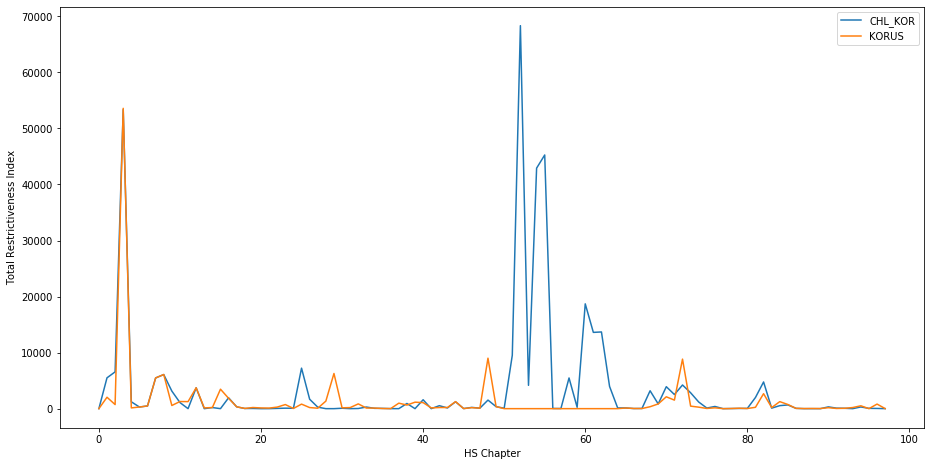

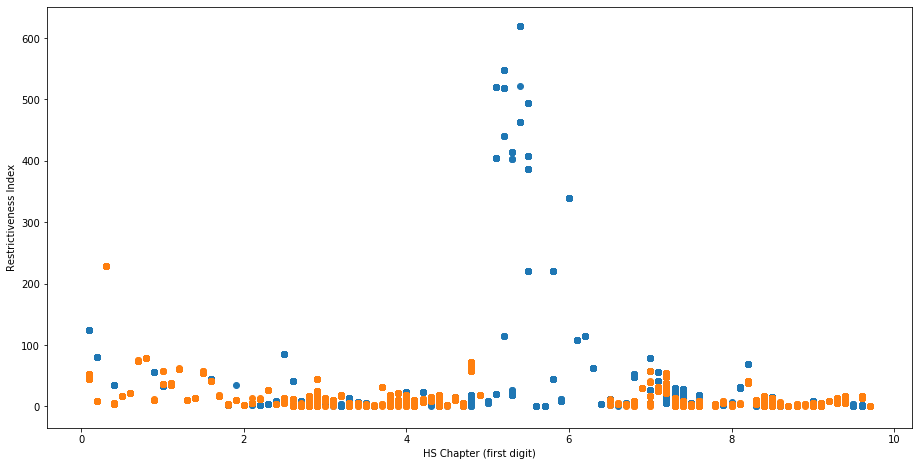

In [140]:
with open('KORUS.txt', mode='r', encoding='utf-8') as f:
    korus = f.read()

KORUS = RoO('KORUS', korus, hs_maps[2017])

plt.figure(figsize=(15.5,7.75))
CHL_KOR.plot_chapter_restrictions()
KORUS.plot_chapter_restrictions()
plt.legend()

plt.figure(figsize=(15.5,7.75))
CHL_KOR.scatter_plot()
KORUS.scatter_plot()

In [255]:
count = 0
for rule in KORUS.get_unique_rules().values():
    res = []
    for pattern in patterns.values():
        res.append(pattern.search(rule))
    if any(res):
        #print(pattern1.search(rule))
        continue
    count += 1
    #print(rule, end='\n\n')
print('Rules left:', count)
    
freq = Counter()
for hsc, rule in KORUS.get_rules().items():
    more = []
    for name, pattern in patterns.items():
        if pattern.search(rule):
            freq[name] += 1
            #break
            more.append(name)
    if len(more) > 1:
        print(more)
        print(rule, end='\n\n')

covered = sum(freq.values())
total = len(KORUS)

print('KORUS')
print('Counter : ', end='')
pprint.pprint(freq.most_common())
print(covered, '/', total, '({:2.2%})'.format(covered / total), end='\n\n')

Rules left: 194
KORUS
Counter : [('CTC', 3717),
 ('CTCo', 142),
 ('CTCe', 121),
 ('CTC+RVCUNIV', 68),
 ('CTCoe', 49)]
4097 / 5053 (81.08%)



In [300]:
with open('NAFTA_ca.txt', mode='r', encoding='utf-8') as f:
    nafta = f.read()

NAFTA = RoO('NAFTA', nafta, hs_maps[2017])

plt.figure(figsize=(15.5,7.75))
NAFTA.plot_chapter_restrictions()
#KORUS.plot_chapter_restrictions()
#plt.legend()

plt.figure(figsize=(15.5,7.75))
NAFTA.scatter_plot()
#KORUS.scatter_plot()

KeyError: '410310'

In [239]:
NAFTA.get_roo_struct().get('Section III')

{'Chapter 15': {'15.01-15.18': 'A change to heading 15.01 through 15.18 from any other chapter, except from heading 38.23.',
  '15.20': 'A change to heading 15.20 from any other heading, except from heading 38.23.',
  '15.21-15.22': 'A change to heading 15.21 through 15.22 from any other chapter.'}}

In [468]:
templ = []
def do_stuff(ya):
    count = 0
    for rule in NAFTA.get_unique_rules().values():
        res = []
        nama = []
        for name, pattern in patterns.items():
            res.append(pattern.search(rule))
            nama.append(name)
        trigger = False
        for i in range(len(res)):
            if res[i]:
                if nama[i] == 'CTCm':
                    pass
                    #print(rule, end='\n\n')
                trigger = True
                continue
        if trigger:
            continue
        count += 1
        if ya:
            pass
            print(rule, end='\n\n')
            templ.append(rule)
    print('Rules left:', count)

    freq = Counter()
    for hsc, rule in NAFTA.get_rules().items():
        more = []
        for name, pattern in patterns.items():
            if pattern.search(rule):
                freq[name] += 1
                #break
                more.append(name)
                #if name == 'CTCe+RVCUNIV': print(rule, end='\n\n')
                #if name == 'CTCm': print(rule, end='\n\n')
                #if name == 'CTC1_or_CTC2m+RVC': print(rule, end='\n\n')
        if len(more) > 1:
            print(more)
            print(rule, end='\n\n')

    covered = sum(freq.values())
    total = len(NAFTA)

    print('NAFTA')
    print('Counter : ', end='')
    pprint.pprint(freq.most_common())
    print(covered, '/', total, '({:2.2%})'.format(covered / total), end='\n\n')

In [544]:
# DON'T FORGET TO PASTE THIS BACK
HS_RANGE_TEXT = r'(?:heading|subheading|tariff item) {0}(?: through {0})?'.format(HS_CODE)
HS_RANGE_TEXT_NC = r'(?:heading|subheading|tariff item) {0}(?: through {0})?'.format(HS_CODE_NC)
HS_TIER = r'(chapter|heading|subheading|tariff item)'
HS_TIER_NC = r'(?:[Cc]hapter|heading|subheading|tariff item)'
CH_NUMBER = r'(\d\d?)\b(?!\.\d)'
CH_NUMBER_NC = r'(?:\d\d?)\b(?!\.\d)'
# Tariff item is truncated into 6 digit
UNIV_RANGE_TEXT = r'(?:{0}(?: through {0})?|{1}(?: through {1})?)'.format(CH_NUMBER, HS_CODE)
UNIV_RANGE_TEXT_NC = r'(?:{0}(?: through {0})?|{1}(?: through {1})?)'.format(CH_NUMBER_NC, HS_CODE_NC)
# NOTE TO SELF: I CHANGED MULTI (NO MORE LOOKAHEAD ON 'any other', AND ALSO CTC1_MULTI -> MORE SPECIFIC)
MULTI0 = r'((?:\s|or|,|{0}|{1}|any (?:other )?{0}|including another|within|outside|that group)+)'.format(HS_TIER_NC, UNIV_RANGE_TEXT_NC)
MULTI0_NC = r'(?:\s|or|,|{0}|{1}|any (?:other )?{0}|including another|within|outside|that group)+'.format(HS_TIER_NC, UNIV_RANGE_TEXT_NC)
# Could actually use possessive quantifier ++, but would result in less captures (some escape), and also comma whether negative lookahead
MULTI = r'((?:U.S.|Canadian|Mexican|\s|or|and|,|-|{0}|{1}|any (?:other )?{0}|including another|within|outside|that group|more than one of the following:|[^;]+of {0} {1})+)'.format(HS_TIER_NC, UNIV_RANGE_TEXT_NC)
MULTI_NC = r'(?:U.S.|Canadian|Mexican|\s|or|and|,|-|{0}|{1}|any (?:other )?{0}|including another|within|outside|that group|more than one of the following:|[^;]+of {0} {1})+'.format(HS_TIER_NC, UNIV_RANGE_TEXT_NC)
INCLUDE = r'(?:, including another {0} within that group)?'.format(HS_TIER_NC)

# (?: [^;]+? of)?
CTC = r'A change to {0} from any other {1}{2}'.format(HS_RANGE_TEXT_NC, HS_TIER, INCLUDE)
CTC_OTG = r'A change to {0} from any(?: other)? {1} outside that group'.format(HS_RANGE_TEXT_NC, HS_TIER)
CTC_ECT = r'A change to {0} from any other {1}{2}, except from {3}'.format(HS_RANGE_TEXT_NC, HS_TIER, INCLUDE, MULTI)
CTC_OTG_ECT = r'A change to {0} from any(?: other)? {1} outside that group, except from {2}'.format(HS_RANGE_TEXT_NC, HS_TIER, MULTI)
# CTC1 Multi, need better way
CTC1_MULTI = r'A change to {0} from {1} or any other {2}'.format(HS_RANGE_TEXT_NC, MULTI, HS_TIER)
CTC1_MULTI_ECT = r'A change to {0} from {1} or any other {2}, except from {3}'.format(HS_RANGE_TEXT_NC, MULTI, HS_TIER, MULTI)
CTC2_MULTI = r'A change to {0} from {1}, whether or not there is also a change from any(?: other)? {2}(?: outside that group)?(?:, including another {2} within (?:{0}|that group)?)?'.format(HS_RANGE_TEXT_NC, MULTI, HS_TIER_NC)
MFTc = r'No required change in tariff classification to {0}, provided(?: that)? non-?originating materials used undergo a chemical reaction(?:, purification, isomer separation or biotechnological processes)? in a Party'.format(HS_RANGE_TEXT_NC)
RVC = r'(?:No(?: required)? change in tariff classification to {0}(?: is required)?, )?provided(?: that)? there is a (?:qualifying|regional) value content of not less than(?:\: (?:a\.|\(a\)))? (\d\d?) per\s?cent(?: under the net cost method| (?:when|where) the (?:[Bb]uild-?down|transaction value) method is used, or (?:of not less than|b\.|\(b\)) (\d\d?) per\s?cent (?:when|where) the (?:[Bb]uild-?up|net cost) method is used)?'.format(HS_RANGE_TEXT_NC)

patterns = {
    'CTC': re.compile(r'^{0}\.$'.format(CTC)),
    'CTCo': re.compile(r'^{0}\.$'.format(CTC_OTG)),
    'CTCe': re.compile(r'^{0}\.$'.format(CTC_ECT)),
    'CTCoe': re.compile(r'^{0}\.$'.format(CTC_OTG_ECT)),
    'CTCm': re.compile(r'^{0}\.$'.format(CTC1_MULTI)),
    'CTCme': re.compile(r'^{0}\.$'.format(CTC1_MULTI_ECT)),
    
    'CTC+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC, RVC)),
    'CTCo+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC_OTG, RVC)),
    'CTCe+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC_ECT, RVC)),
    'CTCoe+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC_OTG_ECT, RVC)),
    'CTCm+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC1_MULTI, RVC)),
    'CTCme+RVC': re.compile(r'^{0}, {1}\.$'.format(CTC1_MULTI_ECT, RVC)),
    
    'CTC_or_RVC': re.compile(r'^{0}; or {1}\.$'.format(CTC, RVC)),
    'CTC_or_MFTc': re.compile(r'^{0}; or {1}\.$'.format(CTC, MFTc)),
    'CTC_or_RVC_or_MFTc': re.compile(r'^{0}; {1}; or {2}\.$'.format(CTC, RVC, MFTc)),
    'CTCe_or_RVC': re.compile(r'^{0}; or {1}\.$'.format(CTC_ECT, RVC)),
    
    'CTC1_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC, CTC2_MULTI, RVC)),
    'CTC1o_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC_OTG, CTC2_MULTI, RVC)),
    'CTC1e_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC_ECT, CTC2_MULTI, RVC)),
    'CTC1oe_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC_OTG_ECT, CTC2_MULTI, RVC)),
    'CTC1m_or_CTC2m+RVC': re.compile(r'^{0}; or {1}, {2}\.$'.format(CTC1_MULTI, CTC2_MULTI, RVC)),
    
    # Need to refine the first multi {0}
    'CTCr': re.compile(r'^A change to {0} from {0} or any other {1}; or A change to {0} from(?: {0} or)? any other {2}\.$'.format(MULTI_NC, HS_TIER, HS_TIER_NC)),
    
    # Unfinished, beware of end, consider "provided that"?
    # multi1 vs descriptor
    'CTCi': re.compile(r'^{0}; or A change to [^;]+ of {1} from {2}\.$'.format(CTC, HS_RANGE_TEXT_NC, MULTI_NC, HS_TIER_NC)),
    'CTCoi': re.compile(r'^{0}; or A change to [^;]+ of {1} from {2}\.$'.format(CTC_OTG, HS_RANGE_TEXT_NC, MULTI_NC, HS_TIER_NC)),
      
    'RVC': re.compile(r'^(?:{0}|A qualifying value content of not less than \d\d? percent)\.$'.format(RVC)),
    'WO': re.compile(r'^(?:Manufacture in which all the materials used are wholly obtained\.|Goods of (?:heading|subheading) {0}(?: through {0})? are wholly obtained or produced entirely in a Party\,? as defined in Article \d\d?\.)$'.format(HS_CODE_NC)),
    'WO_scrap': re.compile(r'^No required change in tariff classification to {0}, provided(?: that)? the waste(?: and scrap are)?(?: is)? wholly obtained or produced entirely in (?:a Party|the Area of one or both Parties|the territory of a Country) as defined in Article \d\d?(?: of Chapter \d\d?)?\.$'.format(HS_RANGE_TEXT_NC)),
    
    'Manufacture': re.compile(r'^Manufacture from (?:yarns|fibres|fabrics|chemical materials or textile pulps)(?:, provided that necessary process stipulated in the Appendix is undertaken)?\.$'),

    'CTC+asean': re.compile(r'^{0}, provided? that, where non-?originating materials of (?:[\w\W]+) are used, each of the non-?originating materials is (?:[^;]+) in (?:(?:either Party or )?a non-?Party|the territory of either Country or a third State) which is a member country of the ASEAN\.$'.format(CTC)),
    'CTCo+asean': re.compile(r'^{0}, provided that, where non-?originating materials of (?:[\w\W]+) are used, each of the non-?originating materials is (?:[^;]+) in either Party or a non-?Party which is a member country of the ASEAN\.$'.format(CTC_OTG)),
    'CTC+asean_or_Manufacture': re.compile(r'^{0}, provided? that, where non-?originating materials of (?:[\w\W]+) are used, each of the non-?originating materials is (?:[\w\W]+) in either Party or a non-?Party which is a member country of the ASEAN; or No required change in tariff classification to {1}, provided that the good is (?:[\w\W]+) and that the non-?originating material of that group is (?:[\w\W]+) in either Party or a non-?Party which is a member country of the ASEAN.$'.format(CTC, HS_RANGE_TEXT_NC)),
    'CTCo+asean_or_Manufacture': re.compile(r'^{0}, provided that, where non-?originating materials of (?:[\w\W]+) are used, each of the non-?originating materials (?:[\w\W]+) in either Party or a non-?Party which is a member country of the ASEAN; or No required change in tariff classification to {1}, provided that the good is (?:[\w\W]+) and that the non-?originating material of that group is (?:[\w\W]+) in either Party or a non-?Party which is a member country of the ASEAN.$'.format(CTC_OTG, HS_RANGE_TEXT_NC)),
    
    'CTC+RVCUNIV': re.compile(r'^{0}, provided that (?:[^;](?!\Z|(?:qualifying|regional) value content))+\.$'.format(CTC)),
    'CTCe+RVCUNIV': re.compile(r'^{0}, provided that (?:[^;](?!\Z|(?:qualifying|regional) value content))+\.$'.format(CTC_ECT)),
    'CTCo+RVCUNIV': re.compile(r'^{0}, provided that (?:[^;](?!\Z|(?:qualifying|regional) value content))+\.$'.format(CTC_OTG)),
    'CTCoe+RVCUNIV': re.compile(r'^{0}, provided that (?:[^;](?!\Z|(?:qualifying|regional) value content))+\.$'.format(CTC_OTG_ECT)),
    
    'CC_fishing': re.compile(r'^A change to {0} from any other chapter, provided that, where non-originating materials of (?:[\w\W]+) are used, each of the non-originating materials is (?:obtained by fishing) in a non-?Party which is a member country of the ASEAN or taken by vessels, which are registered in and sail under the flag of a non-Party which is a member country of the ASEAN, from the sea outside the territorial sea of that non-Party\.$'.format(HS_RANGE_TEXT_NC)),
    
    'pattern_1': re.compile(r'^All the animals of Chapter 1 shall be wholly obtained\.$')
}

start = time.time()
do_stuff(1)
print(time.time() - start)

A change to Canadian tariff item 1806.10.10, U.S. tariff item 1806.10.41 or 1806.10.42 or Mexican tariff item 1806.10.01 from any other heading.

A change to Canadian tariff item 1901.10.31, U.S. tariff item 1901.10.00A, 1901.10.00B, 1901.10.00C or 1901.10.00D or Mexican tariff item 1901.10.01 from any other chapter, except from Chapter 4.

A change to Canadian tariff item 1901.20.11 or 1901.20.21, U.S. tariff item 1901.20.00A, 1901.20.00B, 1901.20.00C, 1901.20.00D, 1901.20.00E or 1901.20.00F or Mexican tariff item 1901.20.02 from any other chapter, except from Chapter 4.

A change to Canadian tariff item 1901.90.31, U.S. tariff item 1901.90.30A, 1901.90.30B, 1901.90.30C, 1901.90.30D, 1901.90.30E, 1901.90.40A, 1901.90.40B, 1901.90.40C, 1901.90.40D, 1901.90.80A, 1901.90.80B, 1901.90.80C, 1901.90.80D, 1901.90.80E, 1901.90.80F or 1901.90.80G or Mexican tariff item 1901.90.03 from any other chapter, except from Chapter 4.

A change to Canadian tariff item 2008.11.20, U.S. tariff item 2008.

A change to Canadian tariff item 8450.90.11, 8450.90.21, 8450.90.31 or 8450.90.41, U.S. tariff item 8450.90.00A or Mexican tariff item 8450.90.01 from any other tariff item.

A change to Canadian tariff item 8450.90.12, 8450.90.22, 8450.90.32 or 8450.90.42, U.S. tariff item 8450.90.00B or Mexican tariff item 8450.90.02 from any other tariff item.

A change to Canadian tariff item 8451.90.11, 8451.90.21 or 8451.90.31, U.S. tariff item 8451.90.00A or Mexican tariff item 8451.90.01 from any other tariff item.

A change to Canadian tariff item 8451.90.12, 8451.90.22 or 8451.90.32, U.S. tariff item 8451.90.00B or Mexican tariff item 8451.90.02 from any other tariff item.

A change to subheading 8456.10 from any other heading, except from more than one of the following: Canadian tariff item 8466.93.11 or 8466.93.91, U.S. tariff 8466.93.10A, 8466.93.50A or 8466.93.70A or Mexican tariff item 8466.93.04, subheading 8537.10, subheading 9013.20.

A change to heading 84.57 from any other heading, 

NAFTA
Counter : [('CTC', 1840),
 ('CTC1e_or_CTC2m+RVC', 679),
 ('CTC1_or_CTC2m+RVC', 608),
 ('CTCe', 528),
 ('CTCo', 378),
 ('CTCe+RVCUNIV', 211),
 ('CTC+RVC', 177),
 ('CTCoe', 175),
 ('CTC1oe_or_CTC2m+RVC', 61),
 ('CTC1o_or_CTC2m+RVC', 45),
 ('CTCoe+RVC', 25),
 ('CTC_or_RVC', 22),
 ('CTCm', 12),
 ('CTCm+RVC', 3),
 ('CTC+RVCUNIV', 2),
 ('CTCe+RVC', 1)]
4767 / 5007 (95.21%)

1.2957851886749268


In [160]:
for iii in sorted(templ, key=len):
    pass
    #print(iii, end='\n\n')

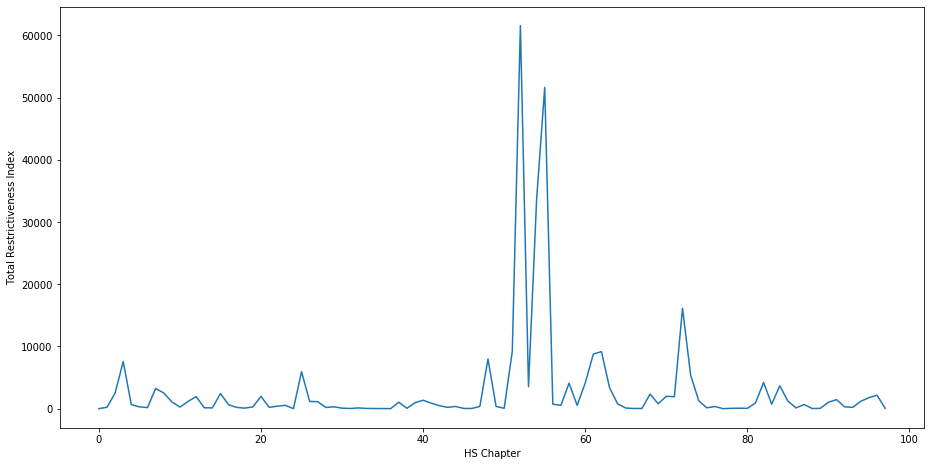

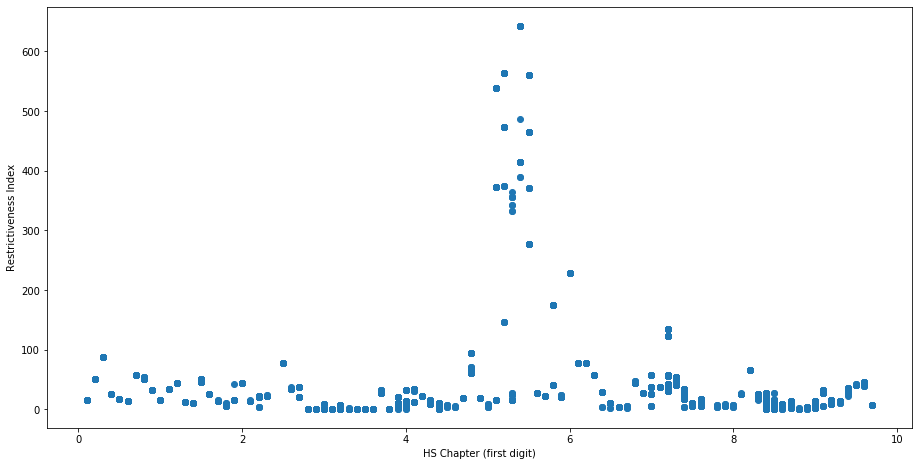

In [531]:
with open('nafta_h4.txt', mode='r', encoding='utf-8') as f:
    nafta = f.read()

NAFTA = RoO('NAFTA', nafta, hs_maps[1992])

plt.figure(figsize=(15.5,7.75))
NAFTA.plot_chapter_restrictions()
#KORUS.plot_chapter_restrictions()
#plt.legend()

plt.figure(figsize=(15.5,7.75))
NAFTA.scatter_plot()
#KORUS.scatter_plot()

In [168]:
dfs = pd.read_stata('RoO_NAFTA.dta')

In [534]:
df_nafta = NAFTA.restrictions_table()

In [536]:
df_nafta = df_nafta.sort_values(by=['output_str', 'input_str']).reset_index(drop=True)

In [541]:
df_nafta.to_stata('NAFTA_v2.dta', write_index=False)

In [442]:
hs0 = np.array([str(i).zfill(6) for i in hsfile['HS1992']])
hs0

array(['010111', '010119', '010120', ..., '970400', '970500', '970600'],
      dtype='<U6')

In [346]:
set(hs0) - set(hsa)

{'151930', '380999'}

In [379]:
hsnew = hs00.loc[(hs00['Product Description'] != '  UN Special Code'), ['Tier', 'ProductCode', 'Product Description']]

In [363]:
hsextra = pd.DataFrame([[3, '151930', '-- Extra addition --'], [3, '380999', '-- Extra addition --']], columns=['Tier', 'ProductCode', 'Product Description'])